```
#BSUB -J guppy
#BSUB -n 30
#BSUB -o %J.stdout
#BSUB -e %J.stderr
#BSUB -R span[hosts=1]
#BSUB -gpu "num=2"

export PATH=/scem/work/mowp/softwares/ont-guppy_6.0.0/ont-guppy/bin:$PATH

guppy_basecaller -c rna_r9.4.1_70bps_hac.cfg -i fast5 --fast5_out --moves_out --bam_out --save_path guppy_out --device "cuda:all:100%"
```

**Note:** The `--fast5_out` parameter is no longer supported in the latest version of Guppy

In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pandas as pd
import numpy as np
from ont_fast5_api.fast5_interface import get_fast5_file
from scipy import stats

In [3]:
fast5_filepath = '/data/Zhaijx/mowp/data/human_drs/fast5/FAW43567_4fe8a7f3_0.fast5'
read_id = '000b91d4-1c12-439f-88f8-0e12b7a39175'
f5 = get_fast5_file(fast5_filepath, mode="r")
read = f5.get_read(read_id)

In [4]:
read.get_analysis_attributes('Basecall_1D_000')

{'component': 'basecall_1d',
 'model_type': 'flipflop',
 'name': 'ONT Guppy basecalling software.',
 'segmentation': 'Segmentation_000',
 'time_stamp': '2023-06-20T08:02:51Z',
 'version': '4.0.11+f1071ce'}

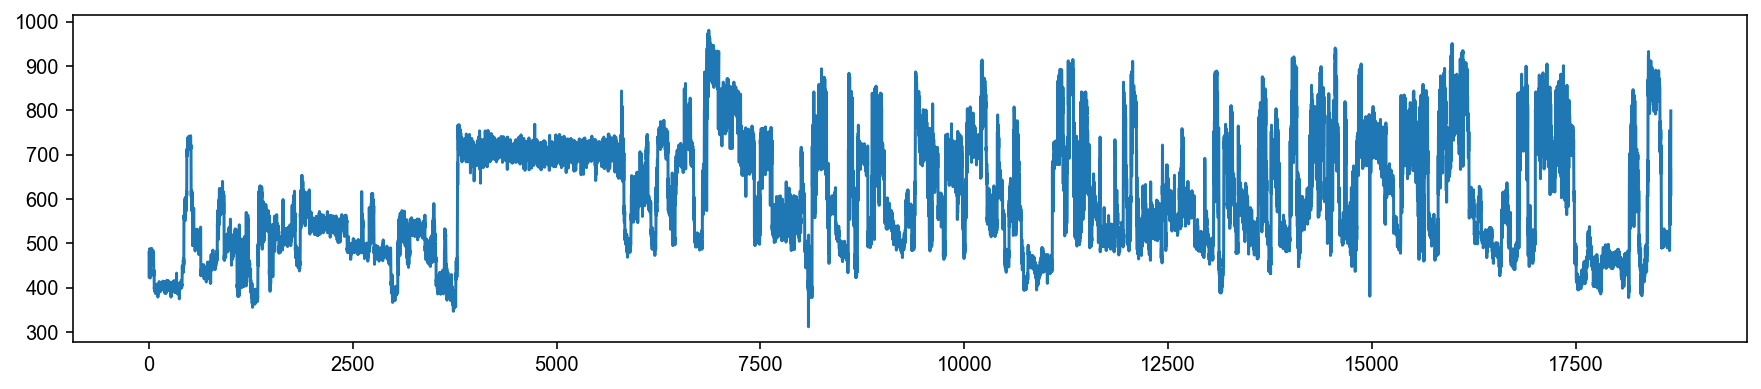

In [5]:
raw_data = read.get_raw_data()
plt.figure(figsize=(15, 3))
plt.plot(raw_data)

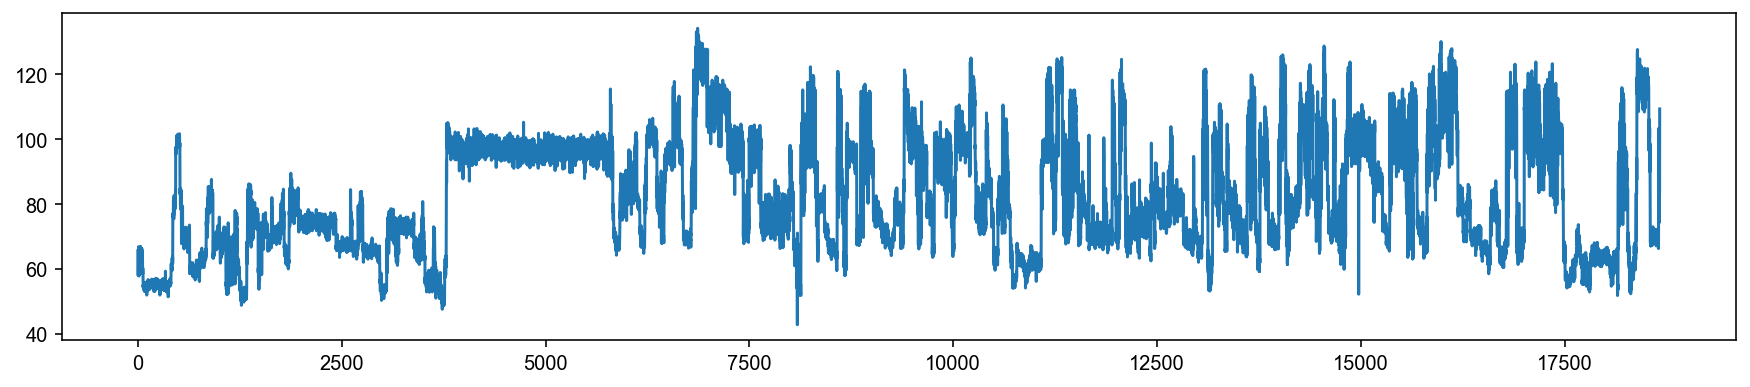

In [6]:
pA = read.get_raw_data(scale=True)
plt.figure(figsize=(15, 3))
plt.plot(pA)

Text(0.5, 1.0, 'Norm. signal')

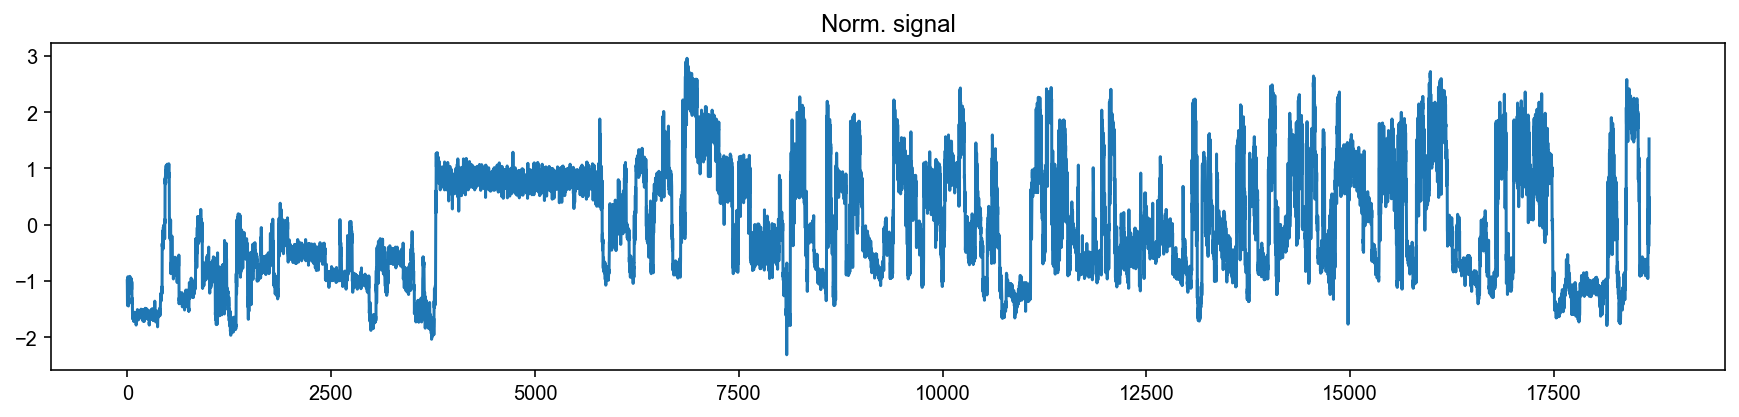

In [7]:
z_pA = stats.zscore(pA)

plt.figure(figsize=(15, 3))
plt.plot(z_pA)
plt.title('Norm. signal')

In [9]:
fastq = read.get_analysis_dataset(group_name='Basecall_1D_000/BaseCalled_template', dataset_name='Fastq')
fastq = fastq.split('\n')[1]
start = read.get_summary_data('Segmentation_000')['segmentation']['first_sample_template']
move = read.get_analysis_dataset(group_name='Basecall_1D_000/BaseCalled_template', dataset_name='Move')
stride = read.get_summary_data('Basecall_1D_000')['basecall_1d_template']['block_stride']
start_col = np.arange(start, start+stride*(len(move)-1)+1, stride)
event_data = pd.DataFrame({'move': move, 'start': start_col, 'move_cumsum': np.cumsum(move)})
event_data['model_state'] = event_data['move_cumsum'].map(lambda x : fastq[x-1:x])
called_events = len(event_data)

In [10]:
 # create event length data for tail normalization
event_length_vector = np.empty(called_events)
event_length_vector[:] = np.nan
count = 0
for i in range(called_events-1, -1, -1):
    if event_data['move'][i] == 1:
        event_length_vector[i] = count + 1
        count = 0
    else:
        count += 1
# multiply moves by length of the event
event_length_vector = event_length_vector * stride
event_data['event_length_vector'] = event_length_vector

In [11]:
event_data_dropna = event_data.dropna().copy()

In [12]:
def get_mean_signal(x, signal_data):
    start = int(x.start)
    end = int(x.start + x.event_length_vector)
    return np.mean(signal_data[start:end])

def get_std_signal(x, signal_data):
    start = int(x.start)
    end = int(x.start + x.event_length_vector)
    return np.std(signal_data[start:end])

In [13]:
event_data_dropna['mean_signal'] = event_data_dropna.apply(get_mean_signal, args=(z_pA, ), axis=1)
event_data_dropna['std_signal'] = event_data_dropna.apply(get_std_signal, args=(z_pA, ), axis=1)

In [14]:
event_data_dropna.head(30)

,move,start,move_cumsum,model_state,event_length_vector,mean_signal,std_signal
0,1,3785,1,G,220.0,0.874461,0.154563
22,1,4005,2,U,1730.0,0.809738,0.123177
195,1,5735,3,C,10.0,0.756746,0.104829
196,1,5745,4,U,10.0,0.635488,0.148917
197,1,5755,5,C,10.0,0.596119,0.157535
198,1,5765,6,U,30.0,0.585358,0.206410
201,1,5795,7,A,10.0,1.107135,0.481506
202,1,5805,8,G,10.0,0.830761,0.226830
203,1,5815,9,A,10.0,0.652023,0.207423
204,1,5825,10,U,10.0,-0.248750,0.171021


In [15]:
event_start = 5735
event_end = 6335-1
show_move_cumsum = True

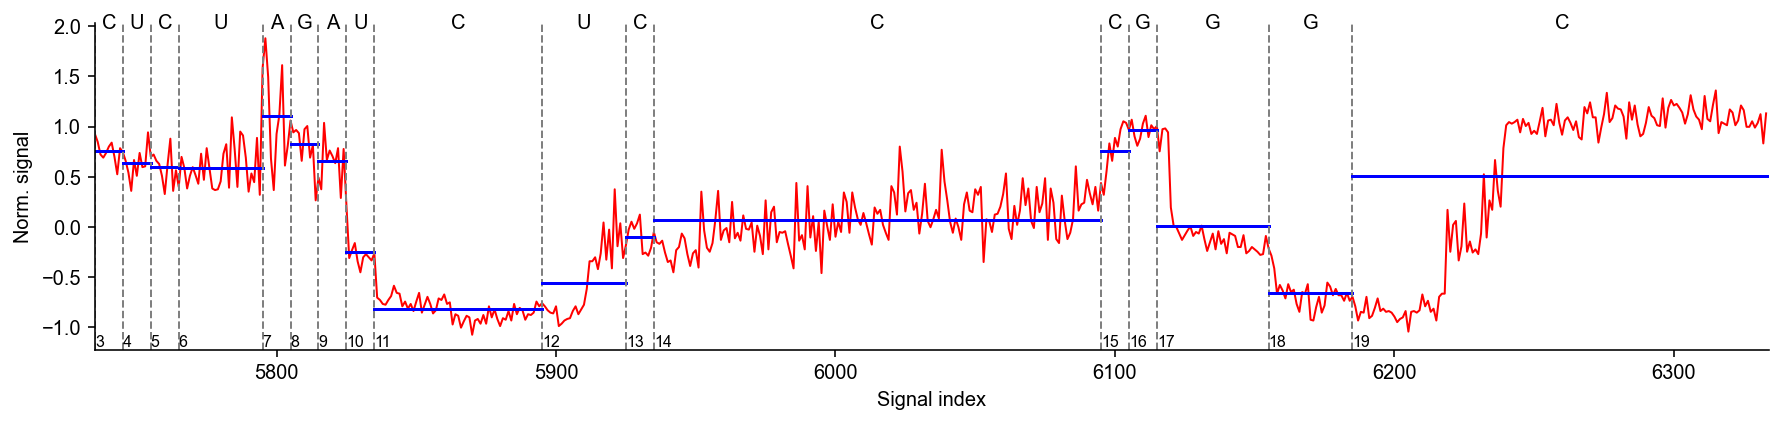

In [16]:
df = event_data_dropna.query('start >= @event_start and start <= @event_end')

plt.figure(figsize=(15, 3))
y = z_pA[event_start:event_end]
x = np.arange(event_start, event_end)
plt.plot(x, y, color='red', lw=1)
ylim = plt.ylim()

for item in df.itertuples():
    plt.axvline(item.start, color='grey', linestyle='--', linewidth=1)
    plt.plot([item.start, item.start+item.event_length_vector], [item.mean_signal, item.mean_signal], color='blue')
    plt.text(item.start+item.event_length_vector/2, ylim[1], item.model_state, ha='center', va='center')
    if show_move_cumsum:
        plt.text(item.start, ylim[0], item.move_cumsum, ha='left', va='bottom', fontsize=8)

plt.xlim(event_start, event_end)
plt.ylabel('Norm. signal')
plt.xlabel('Signal index')

sns.despine()